In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPoint
from shapely import wkt
from sklearn.semi_supervised import LabelPropagation
from imblearn.over_sampling import SMOTE
from glob import glob
import os
import tqdm

import sys
module_path = "/STORAGE/SHARE/Library/"
sys.path.append(module_path)
from method import CPA_TimeDistEx


class SV10Preprocess:
    def __init__(self):
        pass
    
    def run_preprocessing(self,data):
        data = self._set_features(data)
        data = self._drop_features(data)
        return data
    
    def run_semi_preprocessing(self,data):
        data = self._semi_add_features(data)
        data = self._match_LOA(data)
        data = self._classify_Sp_ST(data)
        data = self._isin_Port_Return(data)
        data = self._drop_features(data)
        return data
        
    def _set_features(self,data):
        '''
        Feature setting, Add Variable Function 
        
        '''
        # Exception SHIP_CODE
        data.loc[data['os_SHIP_CODE'].str.startswith('UNKNOWN') == True,'os_SHIP_CODE'] = 'TZ010f22'
        data.loc[data['st_SHIP_CODE'].str.startswith('UNKNOWN') == True,'st_SHIP_CODE'] = 'TZ010f22'
        # ADD RNG
        # Preprocee number one
        data['RNG'] = 0
        idxs = data[(data['os_dLon'] > 180) | (data['st_dLon'] > 180) | (data['os_dLat'] > 90) | (data['st_dLat'] > 90)].index
        print(len(idxs))
        data = data.drop(idxs)
        if len(data)!=0:
            def get_dist(row):
                cal = CPA_TimeDistEx(row['os_dLat'], row['os_dLon'],
                                     row['os_dSOG'],
                                     row['os_dCOG'],
                                     row['st_dLat'], row['st_dLon'],
                                     row['st_dSOG'],
                                     row['st_dCOG'], pdDistNMile=0.0)
                return cal[2]
        data['RNG'] = data.apply(get_dist, axis=1)
        # ADD MaxRisk
        data['MaxRisk'] = 0
        data['MaxRisk'] = data[['dTsRisk','dOsRisk']].max(axis=1)       

        return data
    
    def _drop_features(self,data):  
        ## 사용하지 않을 특성을 삭제합니다.
        data = data.drop(['szMsgSendDT', 'szMsgSeq', 'os_SHIP_CODE','st_SHIP_CODE','szAlarmID','lVulCnt','ucState','ucType','szMessage','LOA1','LOA2'],axis=1)
        return data
    
    def _semi_add_features(self,data):
        data['RNG'] = 0
        idxs = data[(data['os_dLon'] > 180) | (data['st_dLon'] > 180) | (data['os_dLat'] > 90) | (data['st_dLat'] > 90)].index
        data = data.drop(idxs)
        if len(data)!=0:
            def get_dist(row):
                cal = CPA_TimeDistEx(row['os_dLat'], row['os_dLon'],
                                     row['os_dSOG'],
                                     row['os_dCOG'],
                                     row['st_dLat'], row['st_dLon'],
                                     row['st_dSOG'],
                                     row['st_dCOG'], pdDistNMile=0.0)
                return cal[2]
        data['RNG'] = data.apply(get_dist, axis=1)
        # ADD MaxRisk
        data['MaxRisk'] = 0
        data['MaxRisk'] = data[['dTsRisk','dOsRisk']].max(axis=1)  
        data['LOA1'] = 0
        data['LOA2'] = 0 
        data.loc[data['os_SHIP_CODE'].str.startswith('A') == True,'LOA1'] = 17.59
        data.loc[data['st_SHIP_CODE'].str.startswith('A') == True,'LOA2'] = 16.45
        data = data[(data['LOA1'] != 0) & (data['LOA2'] != 0)].reset_index(drop=True)
        
        print('UnLabel Data Add Derived Feature: END')
        return data
        
    
    def _isin_Port_Return(self,data):
        # Port Is In Function 
        # preprcoess number Two 
        dirPath = '/STORAGE/DATA/04_KOREA_PORT_POLYGON_DATA/CSV/'
        fileList = glob(os.path.join(dirPath,'*.csv'))
        dfs = []
        for file in fileList:
            dfs.append(pd.read_csv(file))
        df_geo = pd.concat(dfs,ignore_index = True)
        df_geo['geometry'] = df_geo['Polygon'].apply(wkt.loads)
        df_geo = gpd.GeoDataFrame(df_geo.loc[:,['Port','geometry']], crs='epsg:4326')
        
        def isinport(x):
            return bool(sum(df_geo.geometry.contains(Point(x[1],x[0]))))
        
        isitPort1 = data[['os_dLat','os_dLon']].apply(isinport, axis = 1)
        isitPort2 = data[['st_dLat','st_dLon']].apply(isinport, axis = 1)
        data['isinPort1'] = isitPort1
        data['isinPort2'] = isitPort2
        data = data[(data.isinPort1 == False) & (data.isinPort2 == False)].reset_index(drop=True)
        
        print('Match Port Polygon: END')
        return data
    
    def _match_LOA(self,data):
        data['LOA1'] = 0
        data['LOA2'] = 0 
        
        data.loc[data['os_SHIP_CODE'].str.startswith('A') == True,'LOA1'] = 17.59
        data.loc[data['st_SHIP_CODE'].str.startswith('A') == True,'LOA2'] = 16.45
        data = data[(data['LOA1'] != 0) & (data['LOA2'] != 0)].reset_index(drop=True)
        data = data.drop(labels=['LOA1','LOA2'],axis=1)
        
        dirPath = '/STORAGE/DATA/RawData/MappingTable/'
        name = 'ShipMappingTable.csv'
        df_map = pd.read_csv(dirPath+name,encoding='euc-kr')
        df_map_copy = df_map[['SHIP_CODE','LT']].copy()
        df_join = pd.merge(df_map_copy,data, how = 'right', left_on = 'SHIP_CODE', right_on= 'os_SHIP_CODE')
        df_join = pd.merge(df_map_copy,df_join, how = 'right', left_on = 'SHIP_CODE', right_on= 'st_SHIP_CODE')
        df_join.drop(columns=['SHIP_CODE_x','SHIP_CODE_y'],inplace=True)
        df_join.rename(columns = {'LT_x' : 'LOA2'}, inplace = True)
        df_join.rename(columns = {'LT_y' : 'LOA1'}, inplace = True)
        print('Match LOA: END') 
        return df_join;
    
    def _classify_Sp_ST(self,data):
        # prprocess number Three 
        HO = pd.DataFrame()
        for __, idx in data[data.izCategory == 1].groupby('szAlarmID'):
            if len(idx[['szAlarmID']]) > 30:
                if (idx.MaxRisk.max() > 90) and (idx.MaxRisk.max() - idx.MaxRisk.min() > 10) :
                    HO = pd.concat([HO,idx])
        HO = HO.reset_index(drop=True)
        print(f'Data preprocessing HO {len(HO)} : END')

        CR = pd.DataFrame()
        for __, idx in data[data.izCategory == 2].groupby('szAlarmID'):
            if len(idx[['szAlarmID']]) > 50:
                if (idx.MaxRisk.max() > 90) and (idx.MaxRisk.max() - idx.MaxRisk.min() > 80 ):
                    CR = pd.concat([CR,idx])            
        CR = CR.reset_index(drop=True)
        print(f'Data preprocessing CR {len(CR)} : END')

        OT = pd.DataFrame()
        for __, idx in data[data.izCategory == 3].groupby('szAlarmID'):
            if len(idx[['szAlarmID']]) > 30:
                if (idx.MaxRisk.max() > 90) and (idx.MaxRisk.max() - idx.MaxRisk.min() > 10) :
                    OT = pd.concat([OT,idx])
        OT = OT.reset_index(drop=True)      
        print(f'Data preprocessing OT {len(OT)} : END')
        
        data = pd.concat([HO,CR,OT]).reset_index(drop=True)
        
        print('Data Classify: END')
        return data
              
    def _add_Dummy_Answer(self, data):
        data['ANSWER'] = -1
        return data
    
    def _make_Label_Propagation(self,data_X,data_Y):
        Label_prop_model = LabelPropagation()
        Label_prop_model.fit(data_X,data_Y)
        pred_lb = Label_prop_model.predict(data_X)
        return pred_lb
    
              
    def _SMOTE_func(self,data_X, data_y, strategy = 'auto'):
        #strategy = {} 
        smote = SMOTE(sampling_strategy= strategy)
        X_smote, y_smote = smote.fit_resample(data_X, data_y)
        print('SMOTE 적용 전 train data set: ', data_X.shape, data_y.shape)
        print('SMOTE 적용 후 train data set: ', X_smote.shape, y_smote.shape)
        print('SMOTE 적용 후 label 값 분포: \n', pd.Series(y_smote).value_counts())
        return X_smote, y_smote
    

    def _optimize(self,lb_x,ulb_x,lb_y,ulb_y):
        x = pd.concat([lb_x,ulb_x],axis=0).reset_index(drop=True)
        y = pd.concat([lb_y,ulb_y]).reset_index(drop=True)
        print(f'LabelPropagation 적용 전:{lb_x.shape},{lb_y.shape}')
        print(f'unLabel Data 추가:{ulb_x.shape},{ulb_y.shape}')
        print('Propagation Start')
        y_propa = self._make_Label_Propagation(x,y)
        x['ANSWER'] = y_propa
        print('Propagation END')
        res = self._SMOTE_func(x[['dDCPA','dTCPA','RNG','MaxRisk']],x['ANSWER'],strategy = 'auto')
        res[0]['ANSWER'] = res[1]
        return res[0]

In [2]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
# total 은 EDA 를 위해 apply를 사용하여 컬럼 변경이 있다.
all_csv = glob('/STORAGE/SHARE/seokho/SV10_배포용/지도학습/Train_Data/*.csv')

total = pd.DataFrame()

for csv in tqdm(all_csv):
    temp = pd.read_csv(csv, sep = ',', encoding = 'utf-8')
    total = pd.concat([total, temp])
    total.reset_index(inplace = True)
    total.drop(labels = 'index', axis = 1, inplace = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 55.10it/s]


In [4]:
preprocess = SV10Preprocess()
total = preprocess._set_features(total)

3


In [5]:
# ECS 데이터 MaxRisk 0 인 데이터 ANSWER도 모두 0으로 전처리 해줌 (오류값 전처리)
total.loc[total['MaxRisk'] == 0, 'ANSWER'] = 0
total = total.drop_duplicates()
total.reset_index(drop = True, inplace = True)

<Axes: xlabel='MaxRisk', ylabel='Density'>

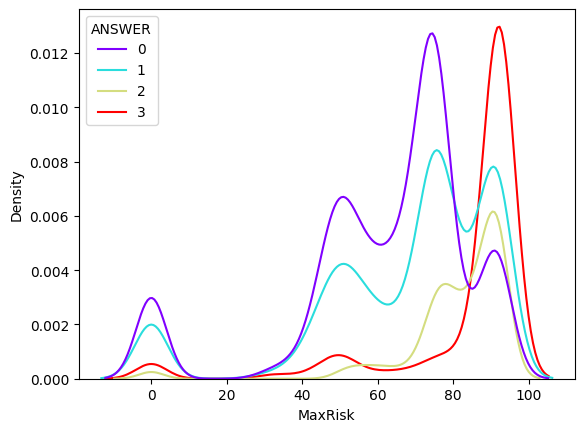

In [12]:
sns.kdeplot(x = 'MaxRisk', hue = 'ANSWER', data = total, palette = 'rainbow')

<Axes: xlabel='dDCPA', ylabel='Density'>

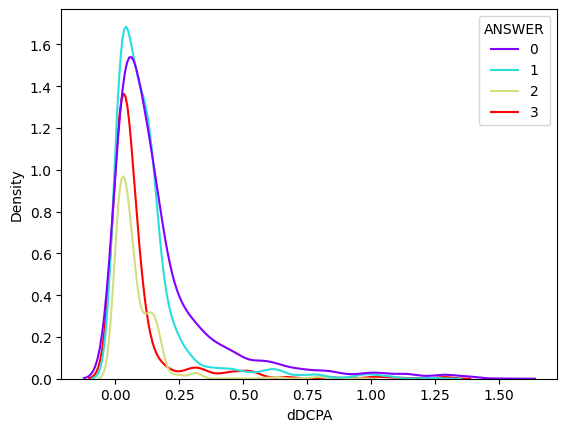

In [13]:
sns.kdeplot(x = 'dDCPA', hue = 'ANSWER', data = total, palette = 'rainbow')

In [8]:
all_csv = glob('/STORAGE/DATA/01_KRISO_G_MAPPED_DATA/CollisionAlarm/*.csv')

random_csv = random.sample(all_csv, 30)

total_ = pd.DataFrame()


for csv in tqdm(random_csv):
    temp = pd.read_csv(csv, sep = ',', encoding = 'utf-8')
    total_ = pd.concat([total_, temp])
    
total_.reset_index(drop = True, inplace = True)

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [01:35<00:00,  3.17s/it]


In [9]:
# 중복제거
total_ = total_.drop_duplicates() # 사용할 df 

In [10]:
preprocess = SV10Preprocess()

# 전처리 1
set_features = preprocess._set_features(total_)
# 전처리 2
match_loa = preprocess._match_LOA(set_features)
# 전처리 3
classify = preprocess._classify_Sp_ST(match_loa)
# 전처리 4
final = preprocess._isin_Port_Return(classify)

# SV10 전처리 객체지향을 통해서 오직 해상 위에서 충돌에 대한 데이터만 가져온 최종 데이터 프레임이다.
final

39264
Match LOA: END
Data preprocessing HO 4731 : END
Data preprocessing CR 6345 : END
Data preprocessing OT 551 : END
Data Classify: END
Match Port Polygon: END


,LOA2,LOA1,szMsgSendDT,szMsgSeq,os_SHIP_CODE,os_dSOG,os_dCOG,os_dLat,os_dLon,dOsCPADist,...,dRisk,dLat,dLon,dDCPA,dTCPA,lVulCnt,RNG,MaxRisk,isinPort1,isinPort2
0,11.0,13.0,20220704124954495,10190,AB090acc,6.9,35.0,34.734982,126.353767,0.017250,...,86.0,34.736551,126.354589,0.171480,0.155997,2,0.171521,71.0,False,False
1,11.0,13.0,20220704124957616,10364,AB090acc,6.8,33.0,34.735058,126.353813,0.017250,...,86.0,34.736551,126.354589,0.171480,0.155997,2,0.166388,71.0,False,False
2,11.0,13.0,20220704125003714,10711,AB090acc,6.7,22.0,34.735225,126.353920,0.362917,...,86.0,34.740822,126.357250,0.058008,3.262464,0,0.167858,51.0,False,False
3,11.0,13.0,20220704125009646,11020,AB090acc,6.8,26.0,34.735397,126.354018,0.311667,...,86.0,34.740075,126.356772,0.000850,2.765382,0,0.162034,67.0,False,False
4,11.0,13.0,20220704125016858,11478,AB090acc,6.7,31.0,34.735585,126.354148,0.247528,...,86.0,34.739252,126.356477,0.028887,2.220979,0,0.154586,70.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9916,8.0,17.0,20230525131743591,44253,AB110c17,1.3,61.0,36.087067,129.508423,0.032861,...,86.0,36.087204,129.509179,0.022145,1.528883,0,0.359417,89.0,False,False
9917,8.0,17.0,20230525131749804,45626,AB110c17,1.3,61.0,36.087082,129.508453,0.032861,...,86.0,36.087209,129.509185,0.021591,1.518002,0,0.336638,89.0,False,False
9918,8.0,17.0,20230525131808056,49796,AB110c17,1.1,67.0,36.087132,129.508530,0.021694,...,86.0,36.087055,129.509201,0.036473,1.191100,0,0.269267,90.0,False,False
9919,8.0,17.0,20230525131811178,50552,AB110c17,0.9,67.0,36.087138,129.508545,0.016000,...,91.0,36.087021,129.509139,0.038758,1.081575,1,0.256201,91.0,False,False


/tmp/ipykernel_498636/1500159872.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x = 'MaxRisk', hue = 'ucLevel', data = final, palette = 'deep')


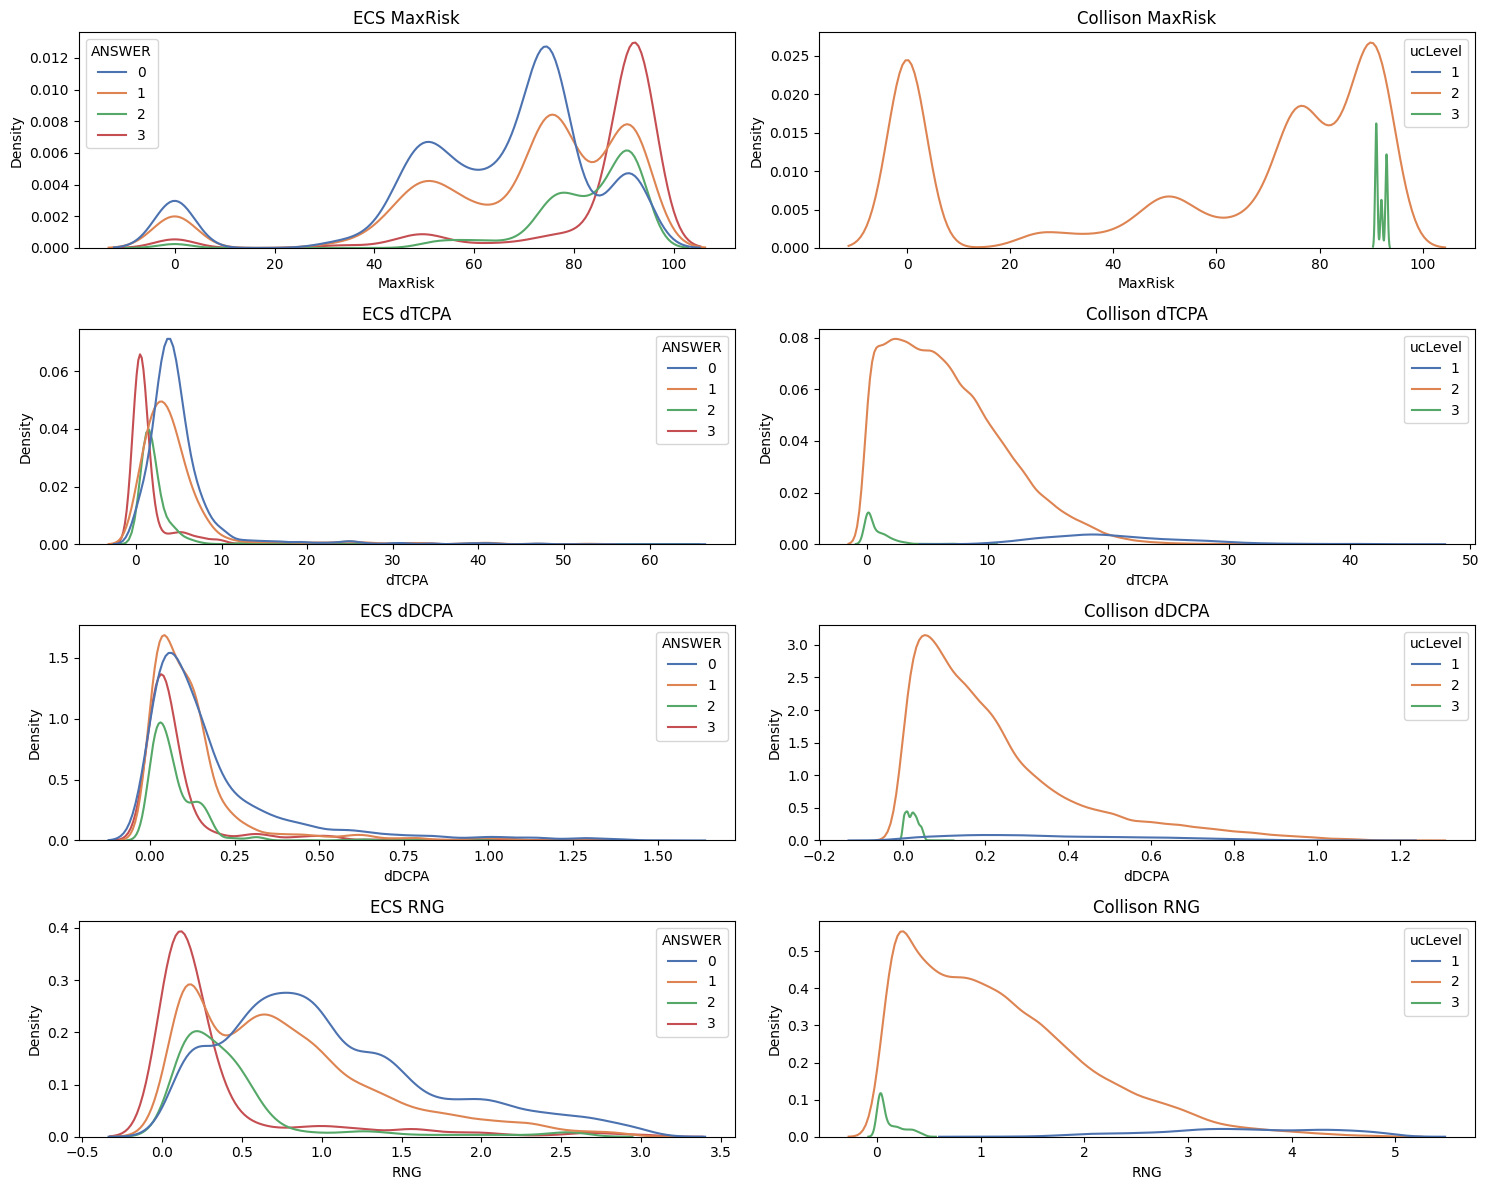

In [32]:
plt.figure(figsize = (15,12))

plt.subplot(4,2,1)
sns.kdeplot(x = 'MaxRisk', hue = 'ANSWER', data = total, palette = 'deep')
plt.title('ECS MaxRisk')

plt.subplot(4,2,2)
sns.kdeplot(x = 'MaxRisk', hue = 'ucLevel', data = final, palette = 'deep')
plt.title('Collison MaxRisk')

plt.subplot(4,2,3)
sns.kdeplot(x = 'dTCPA', hue = 'ANSWER', data = total, palette = 'deep')
plt.title('ECS dTCPA')

plt.subplot(4,2,4)
sns.kdeplot(x = 'dTCPA', hue = 'ucLevel', data = final, palette = 'deep')
plt.title('Collison dTCPA')


plt.subplot(4,2,5)
sns.kdeplot(x = 'dDCPA', hue = 'ANSWER', data = total, palette = 'deep')
plt.title('ECS dDCPA')

plt.subplot(4,2,6)
sns.kdeplot(x = 'dDCPA', hue = 'ucLevel', data = final, palette = 'deep')
plt.title('Collison dDCPA')

plt.subplot(4,2,7)
sns.kdeplot(x = 'RNG', hue = 'ANSWER', data = total, palette = 'deep')
plt.title('ECS RNG')

plt.subplot(4,2,8)
sns.kdeplot(x = 'RNG', hue = 'ucLevel', data = final, palette = 'deep')
plt.title('Collison RNG')


plt.tight_layout()
plt.show()

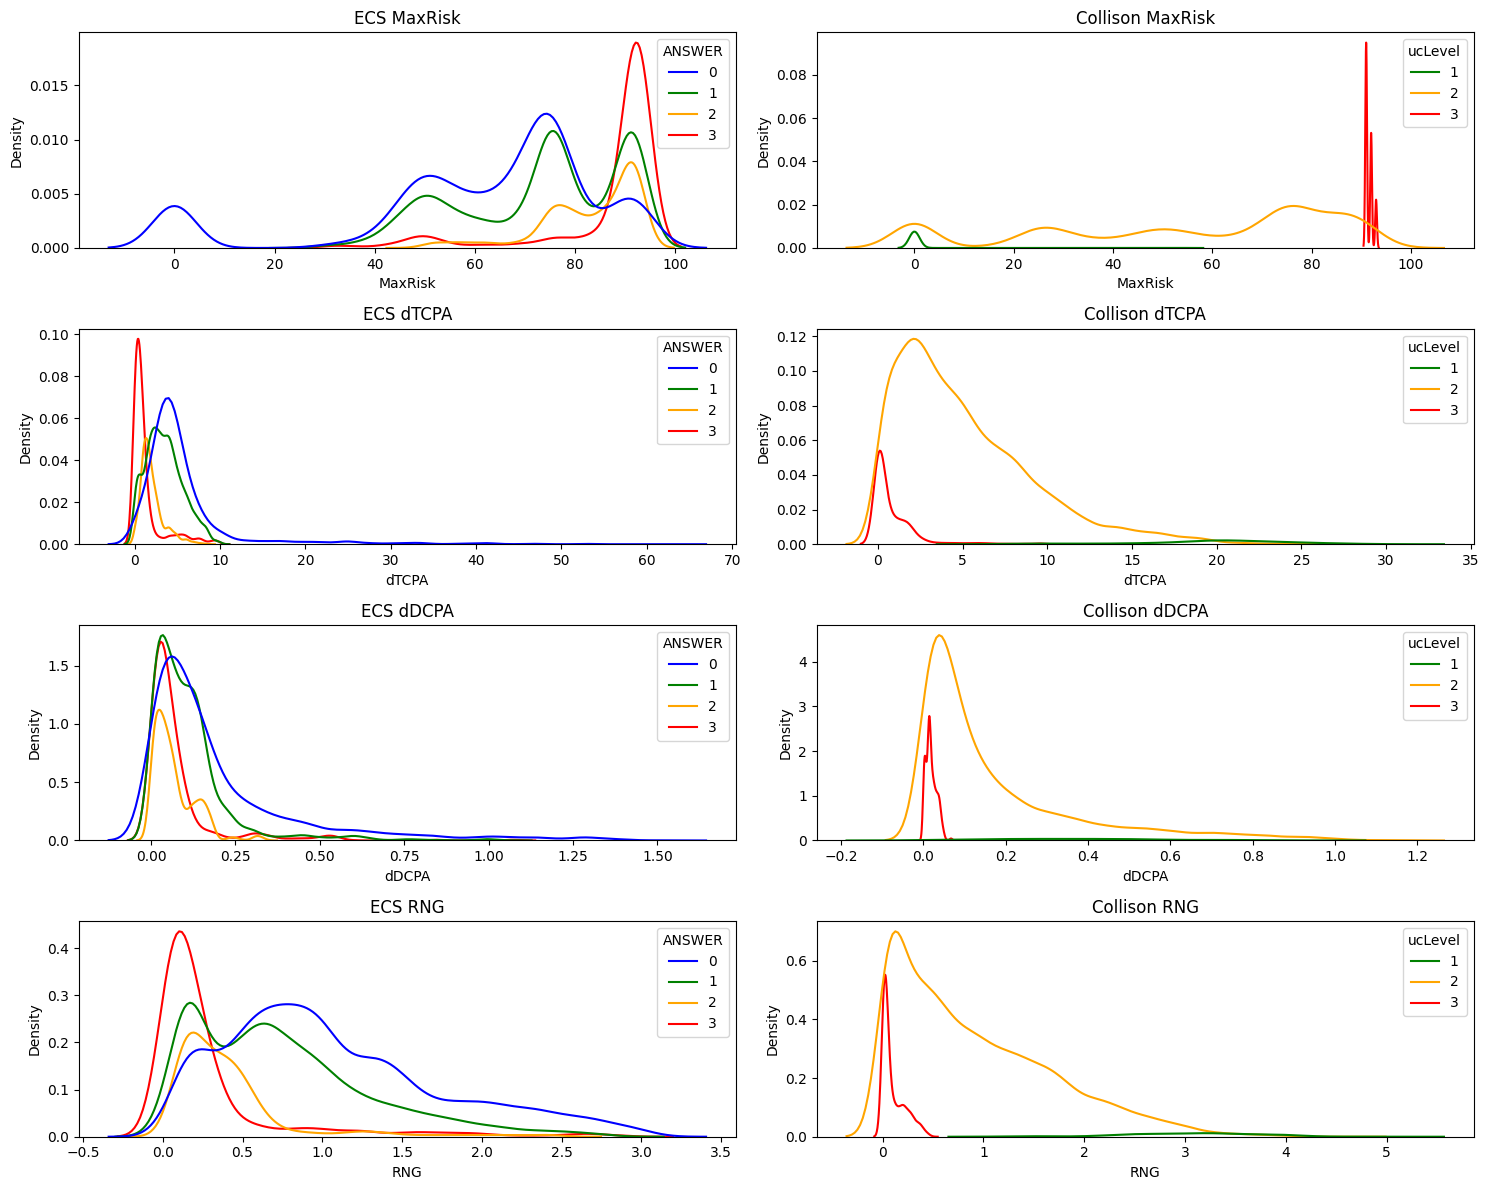

In [199]:
plt.figure(figsize = (15,12))

plt.subplot(4,2,1)
sns.kdeplot(x = 'MaxRisk', hue = 'ANSWER', data = total, palette=['blue','green', 'orange', 'red'])
plt.title('ECS MaxRisk')

plt.subplot(4,2,2)
sns.kdeplot(x = 'MaxRisk', hue = 'ucLevel', data = final, palette=['green', 'orange', 'red'])
plt.title('Collison MaxRisk')

plt.subplot(4,2,3)
sns.kdeplot(x = 'dTCPA', hue = 'ANSWER', data = total, palette=['blue','green', 'orange', 'red'])
plt.title('ECS dTCPA')

plt.subplot(4,2,4)
sns.kdeplot(x = 'dTCPA', hue = 'ucLevel', data = final, palette=['green', 'orange', 'red'])
plt.title('Collison dTCPA')


plt.subplot(4,2,5)
sns.kdeplot(x = 'dDCPA', hue = 'ANSWER', data = total, palette=['blue','green', 'orange', 'red'])
plt.title('ECS dDCPA')

plt.subplot(4,2,6)
sns.kdeplot(x = 'dDCPA', hue = 'ucLevel', data = final, palette=['green', 'orange', 'red'])
plt.title('Collison dDCPA')

plt.subplot(4,2,7)
sns.kdeplot(x = 'RNG', hue = 'ANSWER', data = total, palette=['blue','green', 'orange', 'red'])
plt.title('ECS RNG')

plt.subplot(4,2,8)
sns.kdeplot(x = 'RNG', hue = 'ucLevel', data = final, palette=['green', 'orange', 'red'])
plt.title('Collison RNG')


plt.tight_layout()
plt.savefig('between.png')
plt.show()

In [ ]:
####################   ecs 2 2 3

In [14]:
x = [0,1,2,3] # ANSWER

In [15]:
selected_col = ['dDCPA', 'dTCPA', 'RNG']

In [16]:
# ecs
sel_y = []

for col in selected_col:
    for i in range(4):        
        sel_y.append(total[total.ANSWER.values == i][col].mean())     
sel_y

dcpa = sel_y[:4]
tcpa = sel_y[4:8]
rng = sel_y[8:]

In [17]:
tcpa

[5.5214504249757725,
 3.4587736448495696,
 1.9861804553428373,
 1.2388657229532836]

In [18]:
print(total[total.ANSWER.values == 0].dTCPA.mean())
print(total[total.ANSWER.values == 1].dTCPA.mean())
print(total[total.ANSWER.values == 2].dTCPA.mean())
total[total.ANSWER.values == 3].dTCPA.mean()

5.5214504249757725
3.4587736448495696
1.9861804553428373


1.2388657229532836

In [48]:
val1 = total[total.ANSWER.values == 0].RNG.value_counts().to_frame().reset_index()
val2 = total[total.ANSWER.values == 1].RNG.value_counts().to_frame().reset_index()
val3 = total[total.ANSWER.values == 2].RNG.value_counts().to_frame().reset_index()

<BarContainer object of 1738 artists>

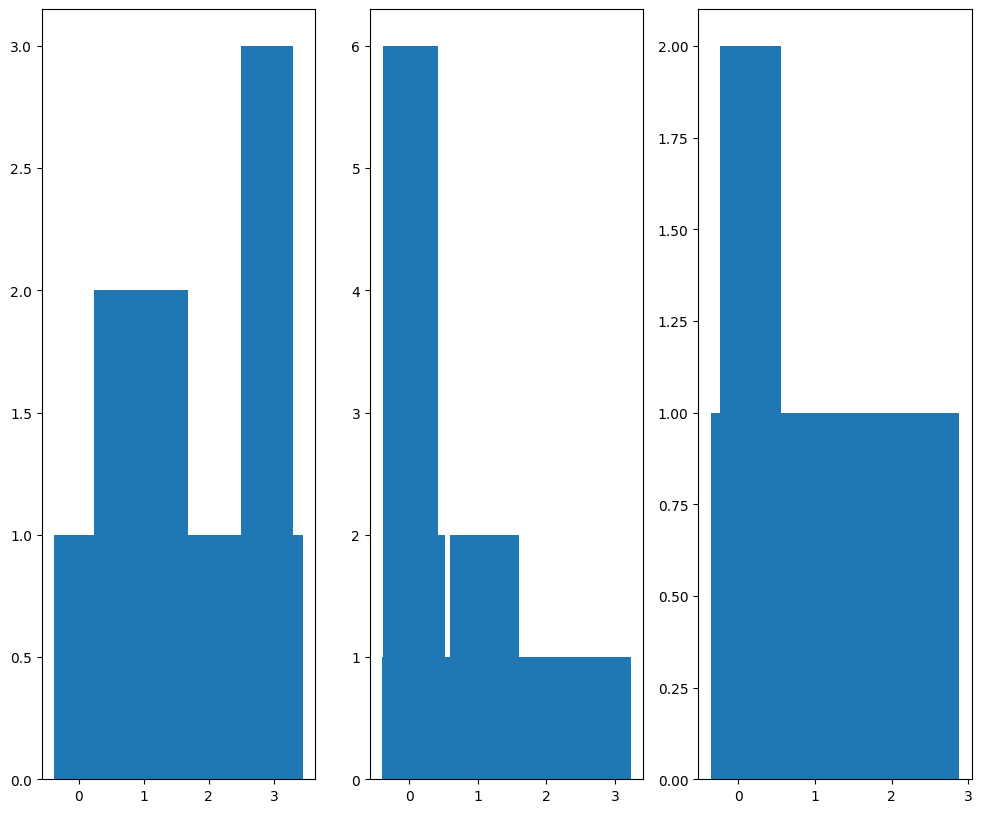

In [50]:
plt.figure(figsize = (12,10))
plt.subplot(1,3,1)
plt.bar(val1['RNG'], val1['count'])

plt.subplot(1,3,2)
plt.bar(val2['RNG'], val2['count'])

plt.subplot(1,3,3)
plt.bar(val3['RNG'], val3['count'])

In [ ]:
####################### collison 2 2 4

In [37]:
coli_x = [1,2,3]

In [38]:
selected_col = ['dDCPA', 'dTCPA', 'RNG']
coli_y = []

for col in selected_col:
    for i in range(1,4):        
        coli_y.append(final[final.ucLevel.values == i][col].mean())     

coli_dcpa = coli_y[:3]
coli_tcpa = coli_y[3:6]
coli_rng = coli_y[6:9]

In [39]:
coli_y # collison dcpa + tcpa + rng

[0.492371667117154,
 0.1393432784251279,
 0.021175236572280258,
 16.098760006619827,
 4.7521210777638805,
 0.5264022086856115,
 2.813259203267047,
 0.759854335817382,
 0.07684751409654136]

In [22]:
coli_rng

[2.813259203267047, 0.759854335817382, 0.07684751409654136]

In [23]:
print(final[final.ucLevel.values == 1].RNG.mean())
print(final[final.ucLevel.values == 2].RNG.mean())
final[final.ucLevel.values == 3].RNG.mean()

2.813259203267047
0.759854335817382


0.07684751409654136

In [ ]:
################# ecs 2 2 1

In [25]:
maxrisk = ['MaxRisk']

y = []
for col in maxrisk:
    for i in range(4):
        y.append(total[total.ANSWER.values == i][col].mean())     
y


[60.97485207100592, 73.00635964912281, 82.95344827586207, 86.71029468044394]

In [24]:
print(total[total.ANSWER.values == 0].MaxRisk.mean())
print(total[total.ANSWER.values == 1].MaxRisk.mean())
print(total[total.ANSWER.values == 2].MaxRisk.mean())
total[total.ANSWER.values == 3].MaxRisk.mean()

60.97485207100592
73.00635964912281
82.95344827586207


86.71029468044394

In [ ]:
############## colli 2 2 2

In [26]:
coli_x = [1,2,3] # ucLevel

In [27]:
maxrisk = ['MaxRisk']

coli_maxrisk = []
for col in maxrisk:
    for i in range(1,4):
        coli_maxrisk.append(final[final.ucLevel.values == i][col].mean())     
coli_maxrisk


[1.144927536231884, 49.63257659246198, 91.67480719794345]

In [28]:
# print(total[final.ANSWER.values == 0].MaxRisk.mean())
print(final[final.ucLevel.values == 1].MaxRisk.mean())
print(final[final.ucLevel.values == 2].MaxRisk.mean())
final[final.ucLevel.values == 3].MaxRisk.mean()

1.144927536231884
49.63257659246198


91.67480719794345

In [ ]:
######################  The END

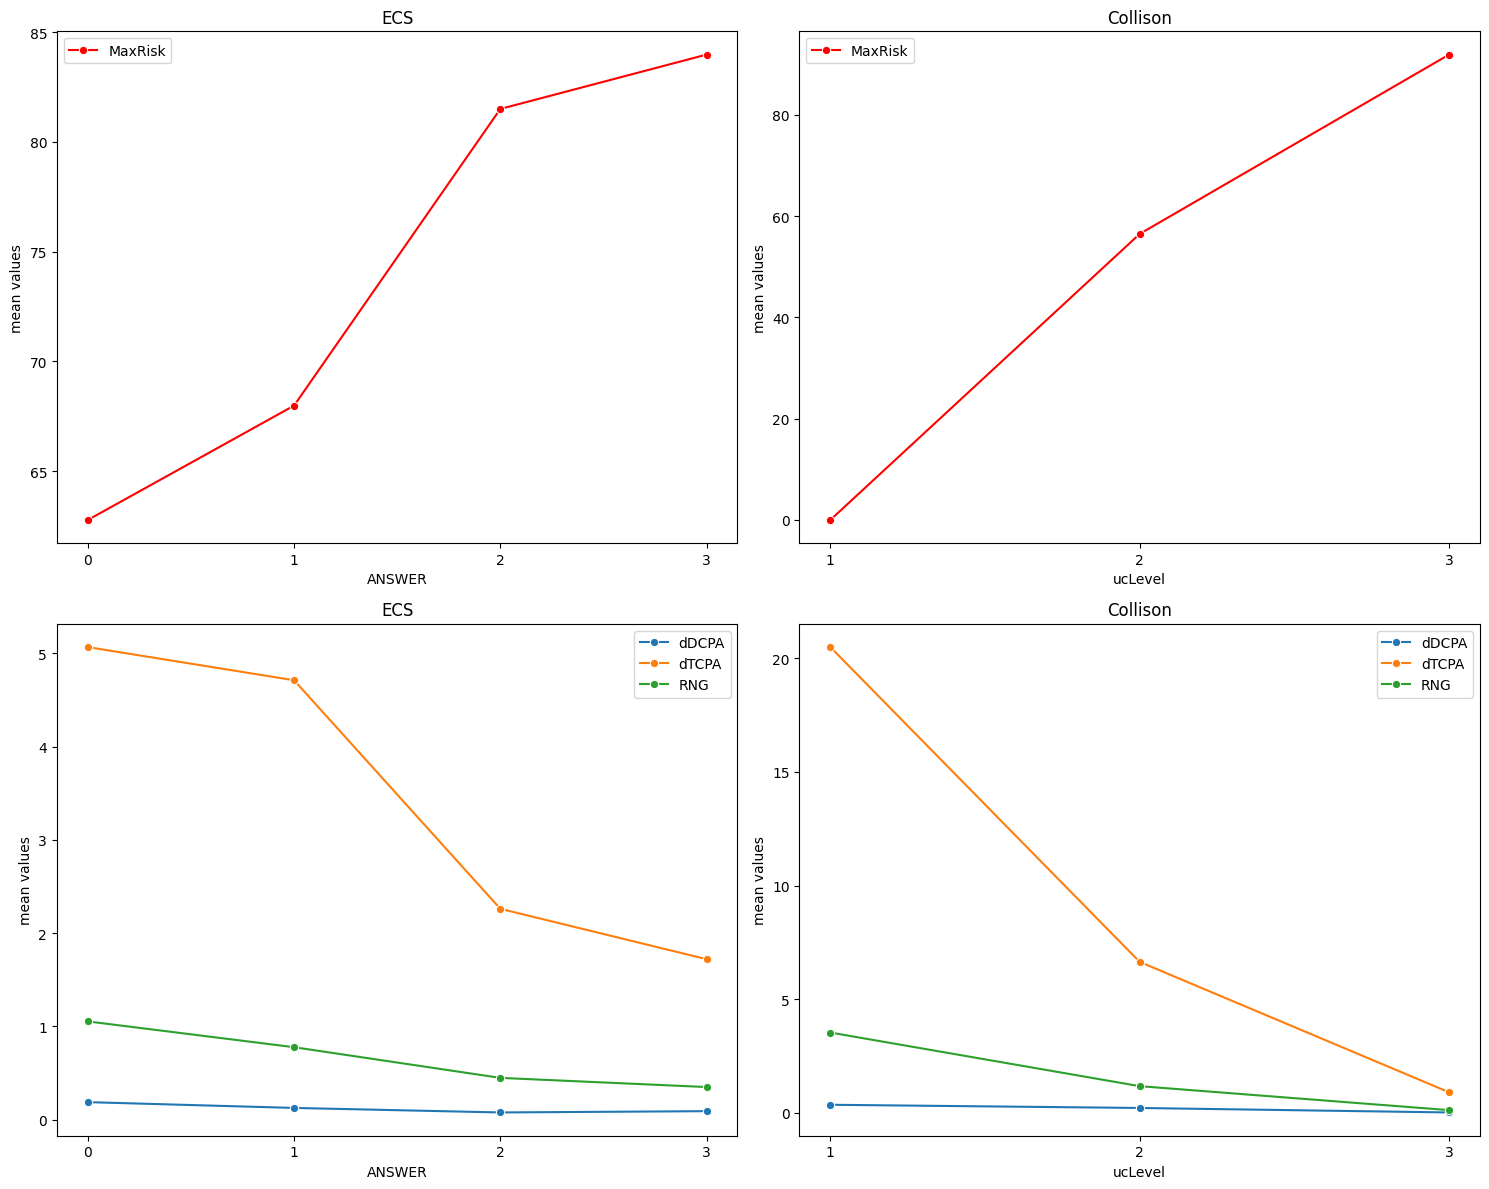

In [202]:
plt.figure(figsize = (15,12))


# min_y = min(min(y), min(coli_y))
# max_y = max(max(y), max(coli_y))

#
plt.subplot(2,2,1)
sns.lineplot(x = x, y = y, marker = 'o', label = 'MaxRisk', color = 'red')

plt.xlabel('ANSWER')
plt.ylabel('mean values')
plt.title('ECS')

plt.xticks(x)
# plt.ylim(min_y, max_y)

#
plt.subplot(2,2,2)
sns.lineplot(x = coli_x, y = coli_y, marker = 'o', label = 'MaxRisk', color = 'red')

plt.xlabel('ucLevel')
plt.ylabel('mean values')
plt.title('Collison')


plt.xticks(coli_x)
# plt.ylim(min_y, max_y)

#

plt.subplot(2,2,3)
sns.lineplot(x = x, y = dcpa, marker = 'o', label='dDCPA')
sns.lineplot(x = x, y = tcpa, marker = 'o', label='dTCPA')
sns.lineplot(x = x, y = rng, marker = 'o', label='RNG')

plt.xticks(x)
# plt.xlim(0,3)
# plt.ylim(0,10)

# plt.xticks(range(4))
# plt.yticks(range(10))

plt.xlabel('ANSWER')
plt.ylabel('mean values')

plt.title('ECS')

#
plt.subplot(2,2,4)
sns.lineplot(x = coli_x, y = coli_dcpa, marker = 'o', label='dDCPA')
sns.lineplot(x = coli_x, y = coli_tcpa, marker = 'o', label='dTCPA')
sns.lineplot(x = coli_x, y = coli_rng, marker = 'o', label='RNG')

plt.xlabel('ucLevel')
plt.ylabel('mean values')
plt.title('Collison')

plt.xticks(coli_x)


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ECS')

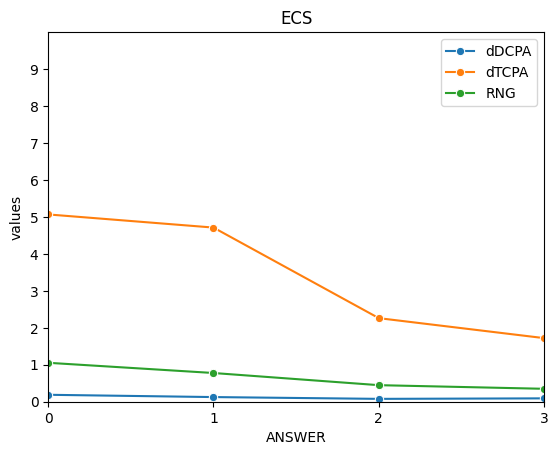

In [181]:
sns.lineplot(x = x, y = dcpa, marker = 'o', label='dDCPA')
sns.lineplot(x = x, y = tcpa, marker = 'o', label='dTCPA')
sns.lineplot(x = x, y = rng, marker = 'o', label='RNG')

plt.xlim(0,3)
plt.ylim(0,10)

plt.xticks(range(4))
plt.yticks(range(10))

plt.xlabel('ANSWER')
plt.ylabel('values')

plt.title('ECS')

In [177]:
total[total.ANSWER.values == 0]['dTCPA'].mean()

5.067363555650909

In [80]:
maxrisk = ['MaxRisk']

y = []
for col in maxrisk:
    for i in range(4):
        y.append(total[total.ANSWER.values == i][col].mean())     
y


[62.77005076142132, 67.98223402082908, 81.50141163184641, 83.97850259451445]

In [52]:
print(total[total.ANSWER.values == 0].MaxRisk.mean())
print(total[total.ANSWER.values == 1].MaxRisk.mean())
print(total[total.ANSWER.values == 2].MaxRisk.mean())
total[total.ANSWER.values == 3].MaxRisk.mean()

62.77005076142132
67.98223402082908
81.50141163184641


83.97850259451445

In [236]:
print(final[final.ucLevel.values == 1].RNG.mean())
print(final[final.ucLevel.values == 2].RNG.mean())
final[final.ucLevel.values == 3].RNG.mean()

3.5358967285906386
1.1784833083356874


0.12416857256637699

In [225]:
coli_y

[0.0, 56.478867524444034, 91.88394062078272]

In [232]:
print(total[total.ANSWER.values == 0].RNG.mean())
print(total[total.ANSWER.values == 1].RNG.mean())
print(total[total.ANSWER.values == 2].RNG.mean())
total[total.ANSWER.values == 3].RNG.mean()

1.0533802178117855
0.7769027891881968
0.44799118002991495


0.3496655271421481

In [233]:
print(coli_tcpa)
print(coli_rng)
coli_dcpa

[20.481780201771926, 6.641606666318826, 0.9104966253402342]
[3.5358967285906386, 1.1784833083356874, 0.12416857256637699]


[0.3606927161056448, 0.21999509730802028, 0.022659804944633846]

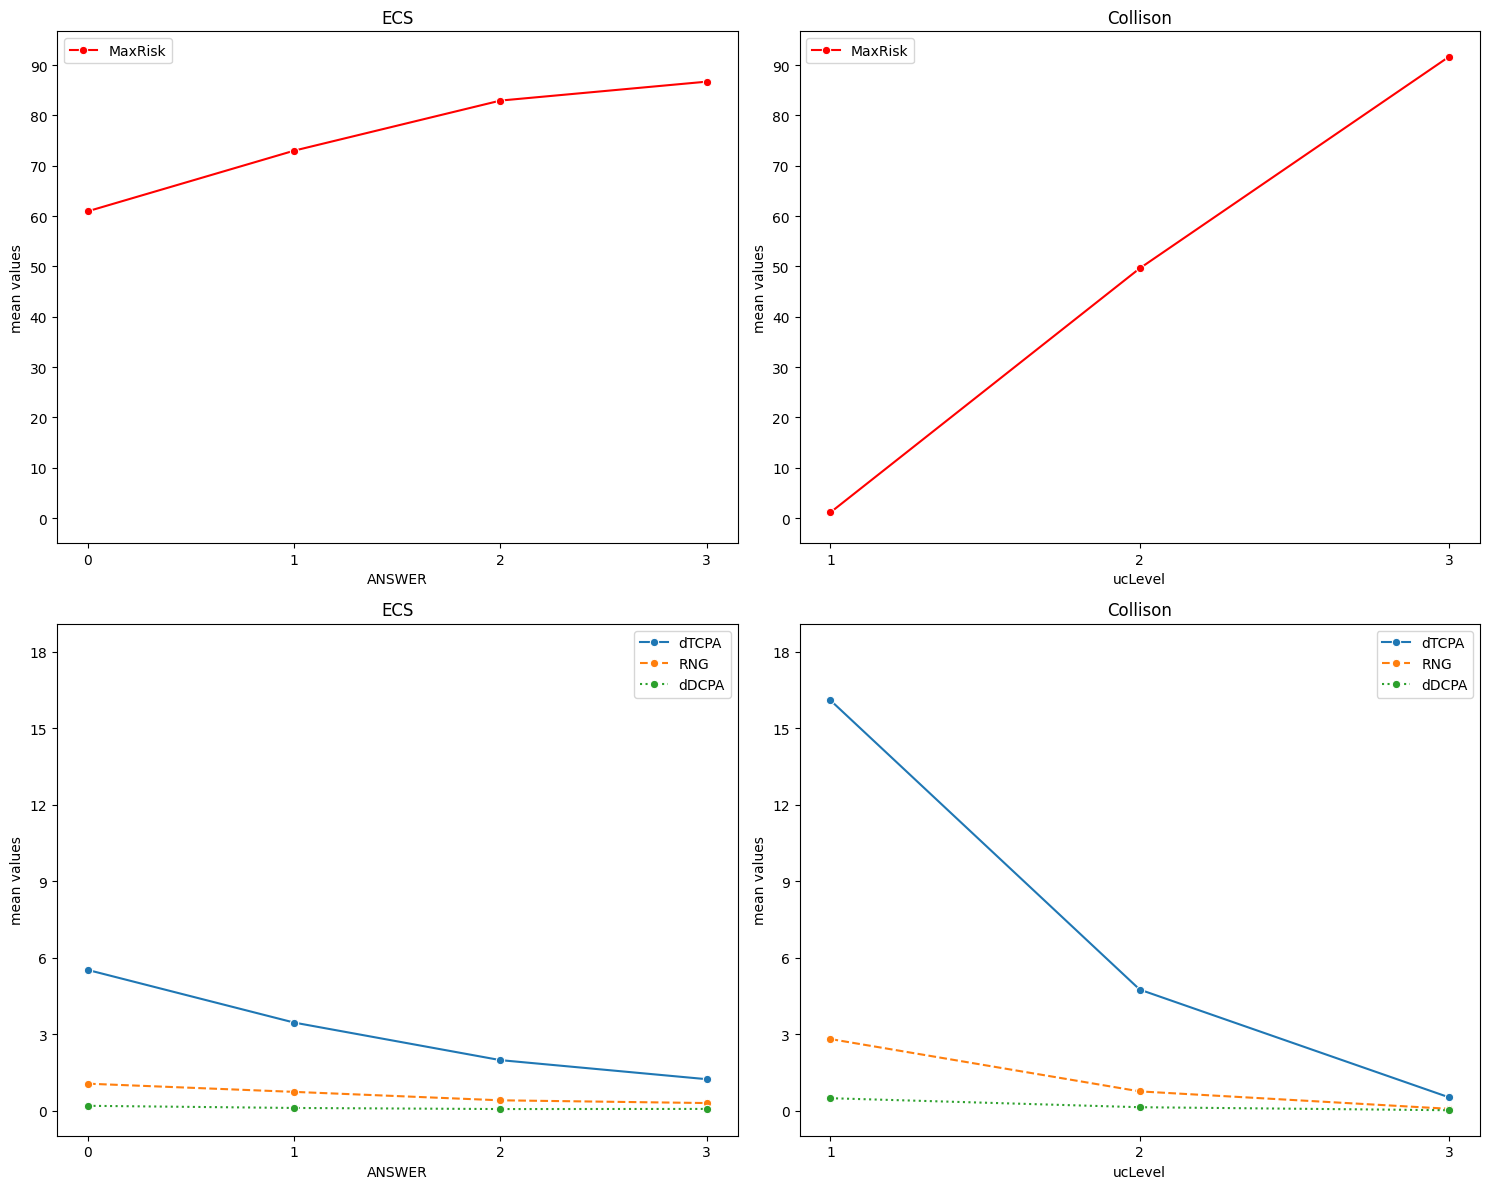

In [51]:
plt.figure(figsize = (15,12))


min_y = min(min(y), min(coli_y) ) -5
max_y = max(max(y), max(coli_y) ) + 10

#
plt.subplot(2,2,1)
sns.lineplot(x = x, y = y, marker = 'o', label = 'MaxRisk', color = 'red')

plt.xlabel('ANSWER')
plt.ylabel('mean values')

plt.title('ECS')

plt.xticks(x)

plt.yticks(range(0, 91, 10))
plt.ylim(min_y, max_y)

plt.legend(loc='upper left')


#
plt.subplot(2,2,2)
sns.lineplot(x = coli_x, y = coli_maxrisk, marker = 'o', label = 'MaxRisk', color = 'red')

plt.xlabel('ucLevel')
plt.ylabel('mean values')

plt.title('Collison')

plt.xticks(coli_x)

plt.yticks(range(0, 91, 10))
plt.ylim(min_y, max_y)



min_y_ = min(min(dcpa), min(coli_dcpa)-1)
max_y_ = max(max(tcpa), max(coli_tcpa) +3 )

#
plt.subplot(2,2,3)
sns.lineplot(x = x, y = tcpa, marker = 'o', label='dTCPA')
sns.lineplot(x = x, y = rng, marker = 'o', label='RNG', linestyle='dashed')
sns.lineplot(x = x, y = dcpa, marker = 'o', label='dDCPA', linestyle='dotted')

plt.xlabel('ANSWER')
plt.ylabel('mean values')

plt.title('ECS')

plt.xticks(x)

plt.yticks(range(0, 21, 3))
plt.ylim(min_y_, max_y_)

#
plt.subplot(2,2,4)
sns.lineplot(x = coli_x, y = coli_tcpa, marker = 'o', label='dTCPA')
sns.lineplot(x = coli_x, y = coli_rng, marker = 'o', label='RNG', linestyle='dashed')
sns.lineplot(x = coli_x, y = coli_dcpa, marker = 'o', label='dDCPA', linestyle='dotted')

plt.xlabel('ucLevel')
plt.ylabel('mean values')

plt.title('Collison')

plt.xticks(coli_x)

plt.yticks(range(0, 21, 3))
plt.ylim(min_y_, max_y_)

#
plt.tight_layout()
plt.savefig('between_line_mean2.png')
plt.show()

In [ ]:
'''
ecs 2 2 1 (labeld data) 의 경우, ANSWER 가 3일 때, MAXRISK 가 80 이하인 좌표들 때문에 mean 값이 86 밖에 안나옴 (이상치 영향)
따라서, 중앙값을 이용 (ANSWER 3 Median : 93)
'''

In [107]:
y

[62.77005076142132, 67.98223402082908, 81.50141163184641, 83.97850259451445]

In [121]:
total[total.ANSWER.values == 3].MaxRisk.median()

92.0

In [109]:
q = total[total.ANSWER.values == 3].MaxRisk

In [114]:
total[total.ANSWER.values ==3]['MaxRisk']

179      86.0
181      87.0
183      89.0
185      89.0
186      90.0
         ... 
15271    93.0
15272    93.0
15273    93.0
15274    93.0
15275    93.0
Name: MaxRisk, Length: 2698, dtype: float64